⏳ Discovering audio files...
✅ Found 172 audio files
🔧 Extracting features (this may take a while)...


Processing: 100%|████████████████████████████████████████████████████████████████████| 172/172 [00:20<00:00,  8.44it/s]


🔮 Clustering audio samples...


Clustering: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.83it/s]



🎧 Cluster 0 samples:
 → 188.mp3
 → 80.mp3
 → 105.mp3

🎧 Cluster 1 samples:
 → 5.mp3
 → 179.mp3
 → 51.mp3

🎧 Cluster 2 samples:
 → 135.mp3
 → 201.mp3
 → 195.mp3

🎧 Cluster 3 samples:
 → 111.mp3
 → 128.mp3
 → 172.mp3
🤖 Training classification model...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3327 - loss: 50.0051 - val_accuracy: 0.6000 - val_loss: 7.5903
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4223 - loss: 31.2886 - val_accuracy: 0.6286 - val_loss: 6.5638
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5313 - loss: 19.1206 - val_accuracy: 0.7143 - val_loss: 3.7519
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5235 - loss: 22.5353 - val_accuracy: 0.6571 - val_loss: 4.2234
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6157 - loss: 15.5221 - val_accuracy: 0.7429 - val_loss: 3.7176
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5305 - loss: 20.4688 - val_accuracy: 0.7143 - val_loss: 

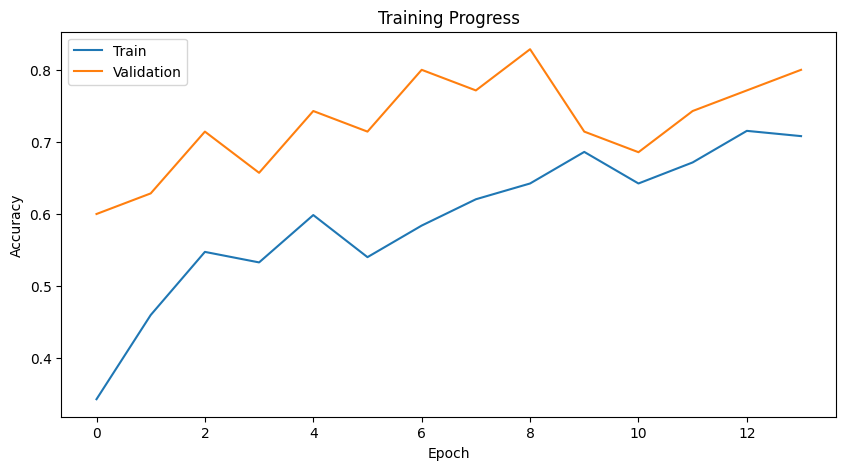

💾 Model saved as music_mood_classifier.keras

🎵 Prediction example: 10.mp3 → energy


In [3]:
import os
import numpy as np
import tensorflow as tf
import librosa
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# ======================
# CONFIGURATION
# ======================
AUDIO_DIR = "MEMD_audio/"
SAMPLE_RATE = 16000
DURATION = 30
N_CLUSTERS = 4
CHUNK_SIZE = 5
N_MFCC = 10
BATCH_SIZE = 16
USE_CACHE = True

# ======================
# FEATURE EXTRACTION
# ======================
def process_chunk(audio_chunk):
    mfcc = librosa.feature.mfcc(
        y=audio_chunk,
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        hop_length=512
    )
    return np.mean(mfcc, axis=1)

def extract_features(file_path):
    try:
        audio, _ = librosa.load(
            file_path,
            sr=SAMPLE_RATE,
            duration=DURATION,
            mono=True
        )
        if len(audio) < SAMPLE_RATE * DURATION:
            audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))
            
        features = []
        for i in range(0, len(audio), SAMPLE_RATE * CHUNK_SIZE):
            chunk = audio[i:i + SAMPLE_RATE * CHUNK_SIZE]
            features.append(process_chunk(chunk))
            
        return np.concatenate(features).flatten()
    except Exception as e:
        print(f"\nSkipped {os.path.basename(file_path)}: {str(e)[:50]}...")
        return None

# ======================
# DATA LOADING & CACHING
# ======================
print("⏳ Discovering audio files...")
audio_files = [os.path.join(AUDIO_DIR, f) for f in os.listdir(AUDIO_DIR) 
             if f.lower().endswith(('.wav', '.mp3'))]
print(f"✅ Found {len(audio_files)} audio files")

cache_file = "features_cache.npy"
valid_files_cache = "valid_files.txt"

if USE_CACHE and os.path.exists(cache_file) and os.path.exists(valid_files_cache):
    print("♻️ Loading features and valid files from cache...")
    all_features = np.load(cache_file)
    with open(valid_files_cache, 'r') as f:
        audio_files = [line.strip() for line in f]
else:
    print("🔧 Extracting features (this may take a while)...")
    all_features = []
    valid_files = []
    
    for file_path in tqdm(audio_files, desc="Processing"):
        features = extract_features(file_path)
        if features is not None:
            all_features.append(features)
            valid_files.append(file_path)
    
    audio_files = valid_files
    all_features = np.array(all_features)
    np.save(cache_file, all_features)
    with open(valid_files_cache, 'w') as f:
        f.write('\n'.join(audio_files))

# ======================
# CLUSTERING
# ======================
print("🔮 Clustering audio samples...")
kmeans = MiniBatchKMeans(
    n_clusters=N_CLUSTERS,
    batch_size=512,
    compute_labels=False,
    random_state=42
)

cluster_labels = np.zeros(len(all_features), dtype=int)

for batch_idx in tqdm(range(0, len(all_features), BATCH_SIZE), 
                   desc="Clustering"):
    start = batch_idx
    end = start + BATCH_SIZE
    batch = all_features[start:end]
    kmeans.partial_fit(batch)
    cluster_labels[start:end] = kmeans.predict(batch)

# ======================
# CLUSTER INSPECTION
# ======================
def play_cluster_samples(cluster_id, num_samples=3):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    samples = np.random.choice(cluster_indices, num_samples, replace=False)
    
    print(f"\n🎧 Cluster {cluster_id} samples:")
    for idx in samples:
        print(f" → {os.path.basename(audio_files[idx])}")
        # Uncomment to play audio in Jupyter:
        # from IPython.display import Audio
        # display(Audio(audio_files[idx]))

for cid in range(N_CLUSTERS):
    play_cluster_samples(cid)

# ======================
# LABEL MAPPING (UPDATE THESE!)
# ======================
CLUSTER_LABELS = {
    0: "chill",   # Update based on actual content
    1: "energetic",
    2: "relaxed",
    3: "upbeat"
}

# ======================
# MODEL TRAINING
# ======================
print("🤖 Training classification model...")

# Verify data alignment
assert len(all_features) == len(cluster_labels), "Feature/label mismatch"
labels = [CLUSTER_LABELS[c] for c in cluster_labels]
label_to_index = {v:k for k,v in CLUSTER_LABELS.items()}
y = np.array([label_to_index[label] for label in labels])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    all_features,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(all_features.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(N_CLUSTERS, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ======================
# VISUALIZATION & SAVING
# ======================
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

model.save("music_mood_classifier.keras")
print("💾 Model saved as music_mood_classifier.keras")

# ======================
# PREDICTION FUNCTIONS
# ======================
def predict_mood(file_path):
    features = extract_features(file_path)
    if features is None:
        return "error_processing_file"
    cluster = kmeans.predict(features.reshape(1, -1))[0]
    return CLUSTER_LABELS[cluster]

def clear_cache():
    if os.path.exists(cache_file):
        os.remove(cache_file)
    if os.path.exists(valid_files_cache):
        os.remove(valid_files_cache)
    print("🧹 Cleared all cache files")

# Test prediction
if len(audio_files) > 0:
    test_file = audio_files[0]
    print(f"\n🎵 Prediction example: {os.path.basename(test_file)} → {predict_mood(test_file)}")